In [1]:
## AUXILIAR: IMPORTS GLOBALES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [2]:
## AUXILIAR: MÉTODO DE SPLIT 80-20
"""
El model.predict() devuelve una serie de valores predecidos del clasificador.

Lo que hace este método es comparar los valores predecidos del clasificador con
los valores de test del clasificador, y en base a eso compara a ver qué tan precisos
fueron los resultados.
"""

def traditional_split(test,predecido):
    print("\nSplit 80-20:")
    print("Accuracy:", accuracy_score(test, predecido))
    print("Precision:", precision_score(test, predecido))
    print("Recall:", recall_score(test, predecido))
    print("F1 Score:", f1_score(test, predecido))

    print("\nReporte completo:\n")
    print(classification_report(test, predecido))

    print("Matriz de confusión:")
    print(confusion_matrix(test, predecido))

In [3]:
## AUXILIAR: MÉTODO DE CROSS-VALIDATION

"""
Para evaluar de forma más robusta y confiable, ahora vamos a probar
con un método de cross-validation, en lugar de hacer una división 80-20.
"""

def cross_validation_split(model: LogisticRegression | RandomForestClassifier | KNeighborsClassifier, 
                     atributos: pd.DataFrame, clasificador: pd.Series):
    # Se utiliza cross-validation con 5 folds.
    # Se utiliza scoring=[] para indicar las métricas que quiero de cada fold.
    # Se utiliza return_train_score=False para indicar que solo quiero las métricas de test.
    resultados = cross_validate(
        model, 
        atributos, 
        clasificador, 
        cv=5, 
        scoring=["accuracy", "precision", "recall", "f1"], 
        return_train_score=False
    )

    # Se utiliza np.mean() para ver el promedio de cada métrica calculada. EJ: [0.79, 0.89, 0.82, 0.74]
    print("\nCross-validation:")
    print("  Accuracy :", np.mean(resultados["test_accuracy"]))
    print("  Precision:", np.mean(resultados["test_precision"]))
    print("  Recall   :", np.mean(resultados["test_recall"]))
    print("  F1 Score :", np.mean(resultados["test_f1"]))


In [4]:
# Carga de datos.
dataset = pd.read_csv('../datasets/personality.csv')

#### LIMPIEZA

Significado de valores:
| Valor   | Significado                                                              |
| ------- | ------------------------------------------------------------------------ |
| `count` | Cantidad de valores **no nulos**                                         |
| `mean`  | Promedio                                                                 |
| `std`   | Desviación estándar (cuánto se dispersan los datos respecto al promedio) |
| `min`   | Valor mínimo                                                             |
| `25%`   | Percentil 25 → 25% de los datos están por debajo de ese valor            |
| `50%`   | Mediana (percentil 50)                                                   |
| `75%`   | Percentil 75 → 75% de los datos están por debajo de ese valor            |
| `max`   | Valor máximo                                                             |

In [5]:
# Análisis Exploratorio.

print("\nInfo general del dataset y tipos de datos por atributo:")
dataset.head()
dataset.info()

print("\nEstadisticas basicas:")
print(dataset.describe())

print("\Filas duplicadas:")
print(dataset.duplicated().sum())

print("\nValores faltantes por atributo:")
print(dataset.isnull().sum())

print("\nTotal de ejemplos con al menos 1 valor nulo:")
print(dataset.isnull().any(axis=1).sum())

print("\nPorcentaje de casos que hay en cada clase de atributo clasificador:")
print(dataset["Personality"].value_counts(normalize=True))



Info general del dataset y tipos de datos por atributo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB

Estadisticas basicas:
       Time_spent_Alone  Social_event_attendance  Going_outside  \
count       2837.000000              2838.000000    2834.000000   
mean           4.505816                 3.963354       3.000000   

<>:10: SyntaxWarning: invalid escape sequence '\F'
<>:10: SyntaxWarning: invalid escape sequence '\F'
C:\Users\mauga\AppData\Local\Temp\ipykernel_10236\3029583514.py:10: SyntaxWarning: invalid escape sequence '\F'
  print("\Filas duplicadas:")


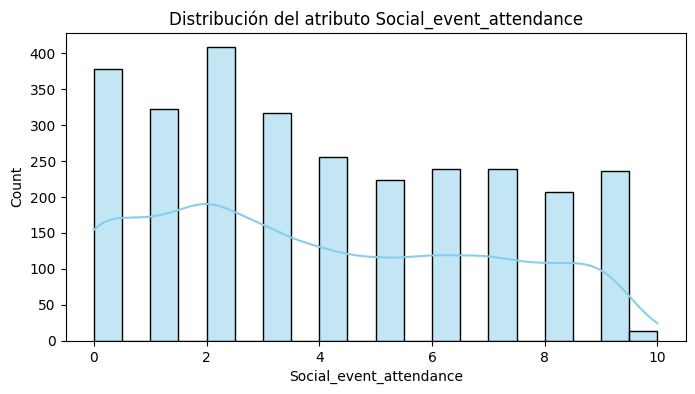

In [6]:
# Análisis de distribución.

"""
Dependiendo si hay una distribución simétrica (normal) o asimétrica
para cada atributo numérico con valores nulos, puedo ver si usar la media
o la mediana a la hora de imputar dichos valores.
"""

columna = 'Social_event_attendance'

plt.figure(figsize=(8,4))
sns.histplot(dataset[columna], kde=True, bins=20, color='skyblue')
plt.title(f"Distribución del atributo {columna}")
plt.show()

In [7]:
# Imputación.

""" 
Se proceden a imputar los valores nulos de los atributos del dataset.
- Para atributos continuos, se utilizará la media.
- Para atributos categóricos, se utilizará la moda.
"""

# Columnas numéricas.
numeric_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
            'Friends_circle_size', 'Post_frequency']

for columna in numeric_cols:
    mediana = dataset[columna].median()
    dataset[columna] = dataset[columna].fillna(mediana)

# Columnas categóricas.
categoric_cols = ['Stage_fear', 'Drained_after_socializing']

for columna in categoric_cols:
    moda = dataset[columna].mode()[0]
    dataset[columna] = dataset[columna].fillna(moda)

# Verificación.
print("\nValores faltantes por atributo:")
print(dataset.isnull().sum())

dataset.head()


Valores faltantes por atributo:
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


#### INTEGRACIÓN
No fue necesario integrar fuentes de datos externas, ya que todo 
el análisis se realizó sobre un único archivo .csv consistente. 
No se requirió combinación con otras tablas ni enriquecimiento externo.

#### TRANSFORMACIÓN

In [8]:
""" 
Se aplica una transformación binaria dado que son atributos categóricos simples.
No son multiclase.
"""

# Transformación binaria para atributos.
dataset["Stage_fear"] = dataset["Stage_fear"].map({ 'Yes': 1, 'No': 0 })
dataset["Drained_after_socializing"] = dataset["Drained_after_socializing"].map({ 'Yes': 1, 'No': 0 })

# Transformación binaria para atributo clasificador.
dataset["Personality"] = dataset["Personality"].map({ 'Extrovert': 1, 'Introvert': 0 })

dataset.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,0,4.0,6.0,0,13.0,5.0,1
1,9.0,1,0.0,0.0,1,0.0,3.0,0
2,9.0,1,1.0,2.0,1,5.0,2.0,0
3,0.0,0,6.0,7.0,0,14.0,8.0,1
4,3.0,0,9.0,4.0,0,8.0,5.0,1


In [9]:
# Escalado utilizando StandardScaler.

# Separar atributos y atributo clasificador.
atributos = dataset.drop("Personality", axis=1)
clasificador = dataset["Personality"]

# Inicializar el escalador.
scaler = StandardScaler()

# Aplicar escalado a los atributos (incluidos los categóricos transformados en 0-1).
atributos_escalados = scaler.fit_transform(atributos)

""" 
En este punto, atributos_escalados quedó como un array de NumPy,
por ende vamos a proceder a pasarlo nuevamente a un DataFrame de pandas
con los nombres originales de columnas.
"""

# Convertir el array de a DataFrame por comodidad (con los mismos nombres de columnas).
atributos_escalados = pd.DataFrame(atributos_escalados, columns=atributos.columns)

# Combinar los atributos escalados y atributo clasificador en un nuevo dataset.
dataset_transformed = atributos_escalados.copy()
dataset_transformed["Personality"] = clasificador.values

# Verificación.
print("\nNuevo dataset con los valores transformados:")
dataset_transformed.head()


Nuevo dataset con los valores transformados:


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,-0.143788,-0.972784,0.019907,1.350613,-0.970772,1.596787,0.500271,1
1,1.309119,1.027977,-1.371160,-1.350613,1.030108,-1.471766,-0.190744,0
2,1.309119,1.027977,-1.023393,-0.450204,1.030108,-0.291553,-0.536251,0
3,-1.306113,-0.972784,0.715440,1.800817,-0.970772,1.832829,1.536793,1
4,-0.434369,-0.972784,1.758740,0.450204,-0.970772,0.416574,0.500271,1


#### MINERÍA Y EVALUACIÓN

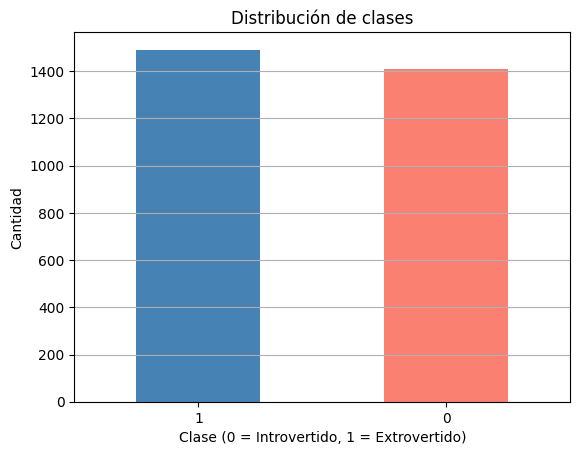

Personality
1    51.413793
0    48.586207
Name: proportion, dtype: float64


In [10]:
# Revisar desbalanceo antes de dividir el dataset.

# Frecuencia absoluta.
dataset["Personality"].value_counts().plot(kind="bar", title="Distribución de clases", color=["steelblue", "salmon"])
plt.xticks(rotation=0)
plt.ylabel("Cantidad")
plt.xlabel("Clase (0 = Introvertido, 1 = Extrovertido)")
plt.grid(axis='y')
plt.show()

# Frecuencia relativa (%).
print(dataset["Personality"].value_counts(normalize=True) * 100)

In [11]:
# División en training set y test set. (Split 80-20)

""" 
Dado que el desbalanceo del dataset es casi inexistente,
se aplicará directamente una división 80-20.
"""

def split_80_20(dataset: pd.DataFrame):
    # Separar atributos y atributo clasificador del dataset transformado.
    atributos = dataset.drop("Personality", axis=1)
    clasificador = dataset["Personality"]

    # Dividir en 80% entrenamiento, 20% test.

    """
    test_size=0.2 Significa que el 20% del dataset se usa para testing, y lo restante para training.
    random_state=42 Es una seed para generar números aleatorios, permite que el split sea reproducible (siempre da la misma división exacta). Si no se coloca nada, en cada ejecución divide distinto.
    stratify=clasificador Sirve para mantener la proporción de clases igual en ambos sets. Es decir, si tengo 52% de extrovertidos y 48% de introvertidos en el dataset, al dividirlo el training set y el test set tendrán ese mismo balance. Sin esto, puede pasar que el test set termine con muchas más instancias de una clase.
    """

    atributos_train, atributos_test, clasificador_train, clasificador_test = train_test_split(
        atributos, clasificador, 
        test_size=0.2, random_state=42, 
        stratify=clasificador
    )

    return atributos_train, atributos_test, clasificador_train, clasificador_test


In [12]:
# Obtener training set y test set.
atributos_train, atributos_test, clasificador_train, clasificador_test = split_80_20(dataset_transformed)

In [13]:
# Entrenar primer modelo: Regresión Logística.

# Inicializar y entrenar el modelo con el training set.
modelo_LR = LogisticRegression()
modelo_LR.fit(atributos_train, clasificador_train)

# Predecir sobre el test set.
clasificador_predecido_LR = modelo_LR.predict(atributos_test)

In [14]:
# Primera iteración: Uso de split 80-20.
traditional_split(clasificador_test, clasificador_predecido_LR)


Split 80-20:
Accuracy: 0.9120689655172414
Precision: 0.9158249158249159
Recall: 0.912751677852349
F1 Score: 0.9142857142857143

Reporte completo:

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       282
           1       0.92      0.91      0.91       298

    accuracy                           0.91       580
   macro avg       0.91      0.91      0.91       580
weighted avg       0.91      0.91      0.91       580

Matriz de confusión:
[[257  25]
 [ 26 272]]


In [15]:
# Segunda iteración: Uso de Cross-Validation.
cross_validation_split(modelo_LR, atributos_escalados, clasificador)


Cross-validation:
  Accuracy : 0.9237931034482758
  Precision: 0.9262415020134235
  Recall   : 0.9255258018899687
  F1 Score : 0.9257997684487332


In [16]:
# Tercera iteración: Cross-Validation + Grid Search.

# Se definen los hiperparámetros a probar.
parametros_LR = {
    'C': [0.01, 0.1, 1, 10, 100], # Inverso de la regularización (cuanto menor, más regulariza)
    'penalty': ['l2'], # Regularización L2 (la más usada)
    'solver': ['lbfgs', 'liblinear'] # Algoritmos de optimización compatibles con L2
}

grid_LR = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_grid=parametros_LR,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    refit='f1',
    cv=5,
    return_train_score=False,
    n_jobs=-1
)

grid_LR.fit(atributos_escalados, clasificador)

print("\nMejor combinación de hiperparámetros [Regresión Logística]:")
print(grid_LR.best_params_)

# Inicializar el modelo de nuevo, con los hiperparámetros ideales.
modelo_LR_optimized = LogisticRegression(C=0.01, penalty='l2', solver='lbfgs')

# Entrenar el modelo con el training set.
modelo_LR_optimized.fit(atributos_train, clasificador_train)

# Utilizar nuevamente cross-validation.
cross_validation_split(modelo_LR_optimized, atributos_escalados, clasificador)


Mejor combinación de hiperparámetros [Regresión Logística]:
{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}

Cross-validation:
  Accuracy : 0.9341379310344827
  Precision: 0.9451951313583523
  Recall   : 0.9255258018899687
  F1 Score : 0.9352067024573854


In [17]:
# Entrenar segundo modelo: Random Forest.

# Inicializar y entrenar el modelo con el training set.
modelo_RFC = RandomForestClassifier(random_state=42)
modelo_RFC.fit(atributos_train, clasificador_train)

# Predecir sobre el test set.
clasificador_predecido_RFC = modelo_RFC.predict(atributos_test)

In [18]:
# Primera iteración: Uso de split 80-20.
traditional_split(clasificador_test, clasificador_predecido_RFC)


Split 80-20:
Accuracy: 0.9051724137931034
Precision: 0.9146757679180887
Recall: 0.8993288590604027
F1 Score: 0.9069373942470389

Reporte completo:

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       282
           1       0.91      0.90      0.91       298

    accuracy                           0.91       580
   macro avg       0.91      0.91      0.91       580
weighted avg       0.91      0.91      0.91       580

Matriz de confusión:
[[257  25]
 [ 30 268]]


In [19]:
# Segunda iteración: Uso de Cross-Validation.
cross_validation_split(modelo_RFC, atributos_escalados, clasificador)


Cross-validation:
  Accuracy : 0.9155172413793103
  Precision: 0.9207147225817947
  Recall   : 0.9148077484231555
  F1 Score : 0.9176260388521948


In [20]:
# Tercera iteración: Cross-Validation + Grid Search.

# Se definen los hiperparámetros a probar.
parametros = {
    'n_estimators': [50, 100, 150, 200, 250, 300], # Cuántos árboles va a crear
    'max_depth': [5, 10, 15, 20, 25, 30] # Profundidad máxima de cada árbol
}

# Se crea el Grid Search.
grid_RFC = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=parametros,
    scoring=['accuracy', 'precision', 'recall', 'f1'], # Le dice que evalue en base a todas las métricas, así evita que se centre solo 1 en una y el resto den muy bajas. Permite combinaciones más equilibradas.
    refit='f1',  # Indica que elija el mejor modelo en base a 1 sola métrica, en este caso F1.
    cv=5,
    return_train_score=False,
    n_jobs=-1  # opcional, usa todos los núcleos
)

# Entrenamiento.
grid_RFC.fit(atributos_escalados, clasificador)

print("\nMejor combinación de hiperparámetros [Random Forest]:")
print(grid_RFC.best_params_)

# Inicializar el modelo de nuevo, con los hiperparámetros ideales.
modelo_RFC_optimized = RandomForestClassifier(random_state=42, max_depth=5, n_estimators=50)

# Entrenar el modelo con el training set.
modelo_RFC_optimized.fit(atributos_train, clasificador_train)

# Utilizar nuevamente cross-validation.
cross_validation_split(modelo_RFC_optimized, atributos_escalados, clasificador)


Mejor combinación de hiperparámetros [Random Forest]:
{'max_depth': 5, 'n_estimators': 50}

Cross-validation:
  Accuracy : 0.9344827586206896
  Precision: 0.9458466049295252
  Recall   : 0.9255258018899687
  F1 Score : 0.9355230811383297


In [21]:
# Entrenar tercer modelo: K-Nearest Neighbors.

# Primera iteración: Uso de split 80-20.
from sklearn.neighbors import KNeighborsClassifier

# Inicializar el modelo con K=5 (valor común de inicio).
modelo_KNN = KNeighborsClassifier(n_neighbors=11, metric='manhattan', weights='uniform')

# Entrenar el modelo con el training set.
modelo_KNN.fit(atributos_train, clasificador_train)

# Predecir sobre el test set.
clasificador_predecido_KNN = modelo_KNN.predict(atributos_test)

In [22]:
# Primera iteración: Uso de split 80-20.
traditional_split(clasificador_test, clasificador_predecido_KNN)


Split 80-20:
Accuracy: 0.9241379310344827
Precision: 0.9409722222222222
Recall: 0.9093959731543624
F1 Score: 0.9249146757679181

Reporte completo:

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       282
           1       0.94      0.91      0.92       298

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580

Matriz de confusión:
[[265  17]
 [ 27 271]]


In [23]:
# Segunda iteración: Uso de Cross-Validation.
cross_validation_split(modelo_KNN, atributos_escalados, clasificador)


Cross-validation:
  Accuracy : 0.9327586206896552
  Precision: 0.945731571165054
  Recall   : 0.9221768310475633
  F1 Score : 0.9337575673579082


In [24]:
# Tercera iteración: Cross-Validation + Grid Search.

# Se definen los hiperparámetros a probar.
parametros_KNN = {
    'n_neighbors': [3, 5, 7, 9, 11], # Valor de K
    'weights': ['uniform', 'distance'], # Cómo se pesan los vecinos
    'metric': ['euclidean', 'manhattan'] # Métrica de distancia
}

# Se crea el Grid Search.
grid_KNN = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=parametros_KNN,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    refit='f1',
    cv=5,
    return_train_score=False,
    n_jobs=-1
)

grid_KNN.fit(atributos_escalados, clasificador)

print("\nMejor combinación de hiperparámetros [K-Nearest Neighbors]:")
print(grid_KNN.best_params_)

# Inicializar el modelo de nuevo, con los hiperparámetros ideales.
modelo_KNN_optimized = KNeighborsClassifier(n_neighbors=11, metric='manhattan', weights='uniform')

# Entrenar el modelo con el training set.
modelo_KNN_optimized.fit(atributos_train, clasificador_train)

# Utilizar nuevamente cross-validation.
cross_validation_split(modelo_KNN_optimized, atributos_escalados, clasificador)


Mejor combinación de hiperparámetros [K-Nearest Neighbors]:
{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}

Cross-validation:
  Accuracy : 0.9327586206896552
  Precision: 0.945731571165054
  Recall   : 0.9221768310475633
  F1 Score : 0.9337575673579082
